In [1]:
# !pip install -e /home/jovyan/PROJECTS/scale-aware-air-sea

In [5]:
from scale_aware_air_sea.utils import open_zarr
# from scale_aware_air_sea.cm26_utils import load_and_combine_cm26
from scale_aware_air_sea.parameters import get_params
import numpy as np
import gcsfs
import matplotlib.pyplot as plt

In [2]:
from distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=3, threads_per_worker=4)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jbusecke/proxy/8787/status,
Dashboard: /user/jbusecke/proxy/8787/status,Workers: 3
Total threads: 12,Total memory: 125.81 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41103,Workers: 3
Dashboard: /user/jbusecke/proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 125.81 GiB
Comm: tcp://127.0.0.1:40219,Total threads: 4
Dashboard: /user/jbusecke/proxy/34077/status,Memory: 41.94 GiB
Nanny: tcp://127.0.0.1:45771,


In [22]:
# load global parameters
primary_algo = 'ecmwf'
n_subsample = 4
subsample = dict(xt_ocean=slice(0, None, n_subsample), yt_ocean=slice(0,None, n_subsample))
time_roi = slice('0180','0182')

# params = get_params('v1.0.0', test=False) 
# ds_offline = open_zarr(params['paths']['CM26']['filter_fluxes'])
# ds_online = open_zarr('gs://cmip6/GFDL_CM2_6/control/ocean_boundary')
# ds_small_scale = open_zarr(params['paths']['CM26']['filter_decomposition_daily_appendix'])
# ds_ice = open_zarr(params['paths']['CM26']['ice_mask'])

# FIXME: Redo this with the new v1 data. I am still running a calculation in the back and do not want to switch branches, so I am going to monkeypatch this for now
ds_offline = open_zarr('gs://leap-persistent/jbusecke/scale-aware-air-sea/results/CM26_fluxes_filter_v0.7.0.zarr')
ds_online = open_zarr('gs://cmip6/GFDL_CM2_6/control/ocean_boundary')
# ds_small_scale = open_zarr('gs://leap-persistent/jbusecke/scale-aware-air-sea/results/CM26_fluxes_filter_decomposed_mean_v0.7.0.zarr')
ds_small_scale_appendix = open_zarr('gs://leap-persistent/jbusecke/scale-aware-air-sea/results/CM26_fluxes_filter_decomposed_daily_appendix_v0.7.0.zarr')


# 
ds_online = ds_online.rename({'sens_heat':'qh', 'evap_heat':'ql'})[['ql', 'qh', 'melt']]

# Apply Ice mask (this should not be necessary anymore in v1.0.0, but double check.
ds_ice = open_zarr('gs://leap-persistent/jbusecke/scale-aware-air-sea/preprocessed/ice_mask_CM26_v0.7.0.zarr')
ds_online = ds_online.where(abs(ds_online.melt) == 0)
ds_offline = ds_offline.where(abs(ds_ice.melt.reset_coords(drop=True)) == 0)
ds_small_scale_appendix = ds_small_scale_appendix.where(abs(ds_ice.melt.reset_coords(drop=True)) == 0)

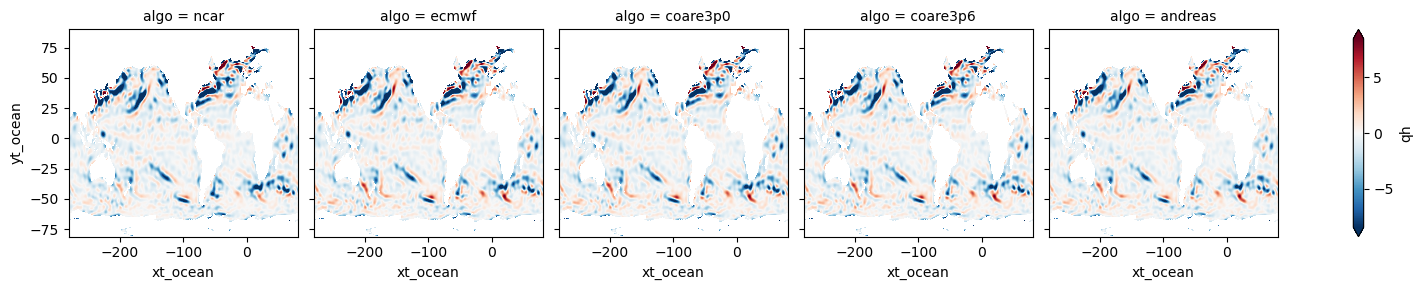

In [7]:
ds_small_scale_appendix.isel(time=0, term=0).qh.plot(col='algo', robust=True)

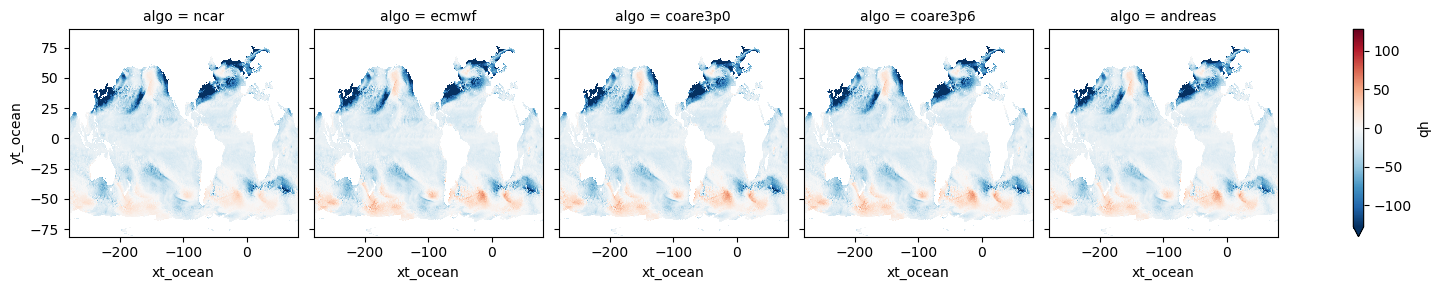

In [8]:
ds_offline.isel(time=0, smoothing=0).qh.plot(col='algo', robust=True)

# Appendix Plots

## Difference between algos (both for full and small scale flux)

In this we can see that the small scale contribution is relatively similar between algos, whereas the absolute (full) flux differs quite a bit (this has been shown in the literature). 

In [9]:
ds_offline_mean = ds_offline[['ql', 'qh']].sel(smoothing='smooth_none').sel(time=time_roi).mean('time').load()
ds_small_scale_appendix_mean = ds_small_scale_appendix.sel(term='Q_star_star').sel(time=time_roi).mean('time').load()
ds_online_mean = ds_online.sel(time=time_roi).mean('time').load()

In [10]:
ds_offline_global_mean = ds_offline[['ql', 'qh']].sel(smoothing='smooth_none').sel(time=time_roi).weighted(ds_offline.area_t).mean(['xt_ocean', 'yt_ocean']).load()
ds_small_scale_appendix_global_mean = ds_small_scale_appendix.sel(term='Q_star_star').sel(time=time_roi).weighted(ds_offline.area_t).mean(['xt_ocean', 'yt_ocean']).load()
ds_online_global_mean = ds_online.sel(time=time_roi).weighted(ds_offline.area_t).mean(['xt_ocean', 'yt_ocean']).load()

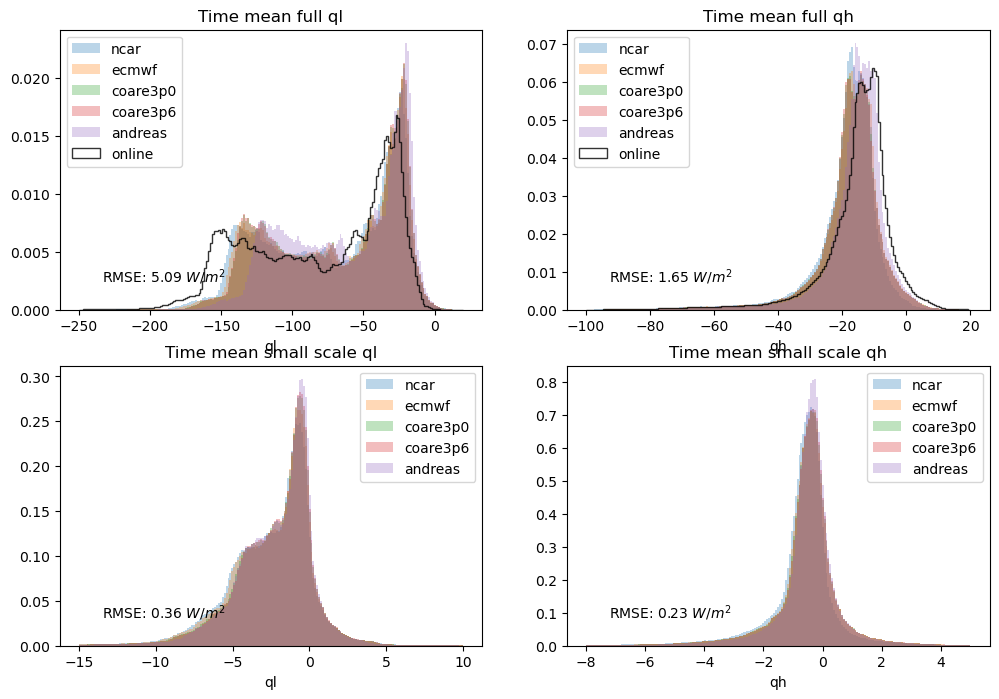

In [12]:
plt.figure(figsize=[12,8])

for i, (var, bins) in enumerate([('ql', np.linspace(-250, 20, 200)), ('qh', np.linspace(-100, 20, 200))]):
    plt.subplot(2,2,i+1)
    da = ds_offline_mean[var]
    da_ref = da.sel(algo=primary_algo)
    da_diff = da.drop_sel(algo='ecmwf') - da_ref
    for algo in da.algo:
        da.sel(algo=algo).plot.hist(bins=bins,alpha=0.3, label=algo, density=True)
        
    # add online flux distribution
    da_online = ds_online_mean[var].plot.hist(bins=bins,alpha=0.8, histtype='step', label='online', density=True, color='k')
    plt.title(f'Time mean full {var}')
    rmse = (da_diff **2).mean(['algo', 'xt_ocean', 'yt_ocean']).pipe(np.sqrt)
    plt.text(0.1, 0.1, f"RMSE: {rmse.data:.2f} $W/m^2$", transform=plt.gca().transAxes)
    plt.legend()
    

for i, (var, bins) in enumerate([('ql', np.linspace(-15, 10, 200)), ('qh', np.linspace(-8, 5, 200))]):
    plt.subplot(2,2,i+3)
    da = ds_small_scale_appendix_mean[var]
    da_ref = da.sel(algo=primary_algo)
    da_diff = da.drop_sel(algo='ecmwf') - da_ref
    for algo in da.algo:
        da.sel(algo=algo).plot.hist(bins=bins,alpha=0.3, label=algo, density=True)
    plt.title(f'Time mean small scale {var}')
    rmse = (da_diff **2).mean(['algo', 'xt_ocean', 'yt_ocean']).pipe(np.sqrt)
    plt.text(0.1, 0.1, f"RMSE: {rmse.data:.2f} $W/m^2$", transform=plt.gca().transAxes)
    plt.legend()

### Compare the global average of the full fluxes and the small scale contribution.

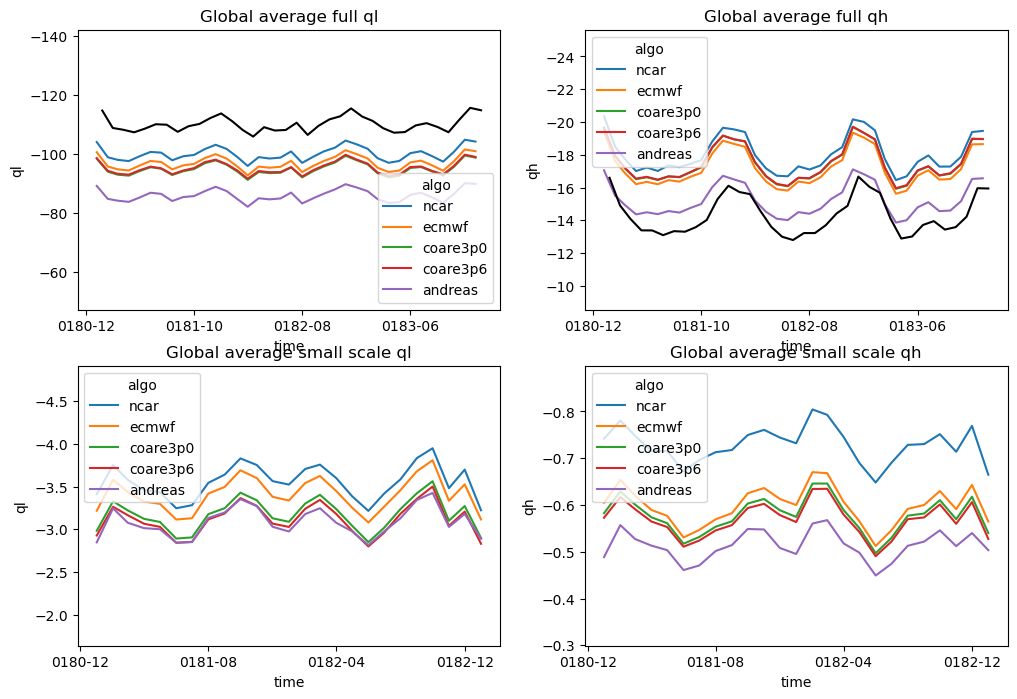

In [14]:
plt.figure(figsize=[12,8])

for i, (var, bins) in enumerate([('ql', np.linspace(-250, 20, 200)), ('qh', np.linspace(-100, 20, 200))]):
    ax = plt.subplot(2,2,i+1)
    da = ds_offline_global_mean[var]
    da.resample(time='1MS').mean().plot(hue='algo')
        
    # add online flux distribution
    ds_online_global_mean[var].plot(color='k')
    plt.title(f'Global average full {var}')
    ylim = np.array([0.5, 1.5])* da.mean().load().data
    ax.set_ylim(ylim)
    

for i, (var, bins) in enumerate([('ql', np.linspace(-15, 10, 200)), ('qh', np.linspace(-8, 5, 200))]):
    ax = plt.subplot(2,2,i+3)
    da = ds_small_scale_appendix_global_mean[var]
    da.resample(time='1MS').mean().plot(ax=ax,hue='algo')
    ylim = np.array([0.5, 1.5])* da.mean().load().data
    ax.set_ylim(ylim)
    ax.set_title(f'Global average small scale {var}')

#### Maybe TODO:
- Add qh and ql to show that the combined signal is much less uncertain, due to the fact that ql is so much larger.


## Compare coarsened to filtered output
